In [ ]:
# The Julia boostrap block
# This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
# so that colab will redirect to the installed Julia kernel
# and then doing your own work

# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm
# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia, PyPlot"; using IJulia; installkernel("Julia")'
# 3. hot-fix patch to strip the version suffix of the installed kernel so that this notebook kernelspec is version agnostic
!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

In [ ]:
# Linear Advection Equation
# ∂u/∂t + c∂u/∂x = 0
# the code and formula are modified from:
# https://peymandavvalo.github.io/linear_1d_advection_equation.html

using SparseArrays, PyPlot
struct LinearAdvection1D
    c::Float64  
    x0::Float64   
    xN::Float64  
    N::Int64    
    deltaT::Float64
    T::Float64
end

N,x0,xN,deltaT,c,T=100, 0., 10., 0.05, 1., 0.5

LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T)

x = collect(range(LA1D.x0, LA1D.xN, length=LA1D.N))

function CFL(m::LinearAdvection1D)
    deltaX = (m.xN - m.x0)/m.N
    return abs(m.c*m.deltaT/deltaX)
end

function checkCFL(m::LinearAdvection1D)
    if (CFL(m)<=1)
        flag=true 
    else
        flag=false
    end
    return flag
end


function solve(u0::Vector, m::LinearAdvection1D, MatrixAssembly::Function)
    u = similar(u0)
    if checkCFL(LA1D)
        println("CFL number is: $(CFL(LA1D))")
        A = MatrixAssembly(LA1D)
        for t in 1:floor(Int, LA1D.T/LA1D.deltaT)
            u = A*u0
            u0 = u
        end
    else
        println("CFL number is greater than 1. CFL: $(CFL(LA1D))")
    end
    return u
end

solve (generic function with 1 method)

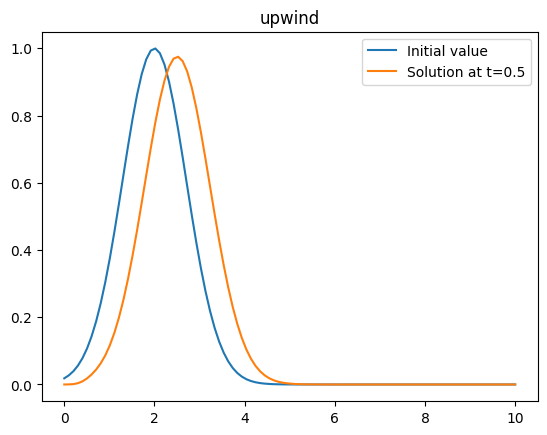

CFL number is: 0.5


PyObject <matplotlib.legend.Legend object at 0x7fb2889fdd90>

In [ ]:
# with upwind method, we get stable solution but a bit less accuracy
function upwindMatrixAssembly(m::LinearAdvection1D)
    alpha_min=min(CFL(m),0)
    alpha_max=max(CFL(m),0)
    a1=fill(alpha_max, m.N-1)
    a2=fill(1+alpha_min-alpha_max, m.N)
    a3=fill(-alpha_min, m.N-1)
    A=spdiagm(-1=>a1,0=>a2,1=>a3)
    A[1,end]=alpha_max
    A[end,1]=-alpha_min
    return A
end

u0 = exp.(-(x .- 2) .* (x .- 2))
u = solve(u0,LA1D,upwindMatrixAssembly)

plot(x, u0, label="Initial value")
plot(x, u, label="Solution at t=$(LA1D.T)")
title("upwind")
legend()


Lax-Wendroff method provide a second order (in time and space) numerical solution. We could write the taylor expansion of $u(x, t+\Delta t)$ with respect to time:

$$
u(x, t+\Delta t)=u(x, t)+\Delta t u_{t}(x, t)+\frac{\Delta^{2} t}{2} u_{t t}(x, t)+O\left(\Delta^{3} t\right)
$$

we konw that $\partial_{t}=-c \partial_{x}$, so:

$$
u(x, t+\Delta t)=u(x, t)-c \Delta t u_{x}(x, t)+c^{2} \frac{\Delta^{2} t}{2} u_{x x}(x, t)+O\left(\Delta^{3} t\right)
$$

with finite difference scheme

$$
u_{i}^{n+1}=a_{-1} u_{i-1}^{n}+a_{0} u_{i}^{n}+a_{1} u_{i+1}^{n}
$$

where $a_{-1}=\frac{1}{2} C(1+C), a_{0}=1-C^{2}, a_{1}=\frac{-1}{2} C(1-C) \text { and } C=\frac{c \Delta t}{\Delta x}$, we will get matrix like:

$$
\mathbf{A}=\left[\begin{array}{ccccccc}
a_{0} & a_{1} & 0 & 0 & 0 & \cdots & a_{-1} \\
a_{-1} & a_{0} & a_{1} & 0 & 0 & \cdots & 0 \\
0 & a_{-1} & a_{0} & a_{1} & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & a_{-1} & a_{0} & a_{1} & 0 \\
0 & 0 & \cdots & 0 & a_{-1} & a_{0} & a_{1} \\
a_{1} & 0 & \cdots & 0 & 0 & a_{-1} & a_{0}
\end{array}\right]_{N \times N}
$$



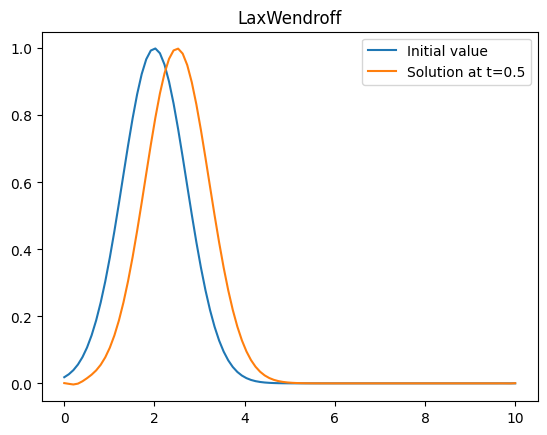

CFL number is: 0.5


PyObject <matplotlib.legend.Legend object at 0x7fb2837955d0>

In [ ]:
function LaxWendroffMatrixAssembly(m::LinearAdvection1D)
    C=CFL(m)
    aleft=C*(1+C)/2
    amid=1-(C*C)
    aright=C*(C-1)/2
    a1=fill(aleft, m.N-1)
    a2=fill(amid, m.N)
    a3=fill(aright, m.N-1)
    A=spdiagm(-1=>a1,0=>a2,1=>a3)
    A[1,end]=aleft
    A[end,1]=aright
    return A
end

u0 = exp.(-(x .- 2) .* (x .- 2))
u = solve(u0,LA1D,LaxWendroffMatrixAssembly)

plot(x, u0, label="Initial value")
plot(x, u, label="Solution at t=$(LA1D.T)")
title("LaxWendroff")
legend()